# pqm

> Pixel Quality Metrics

<!-- Phase linking for PTA requires `cupy.optimize` to be implented which is tracked at
https://github.com/rapidsai/raft/pull/923
and https://github.com/cupy/cupy/issues/6112 -->

In [ ]:
#| default_exp cli/pqm

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
import numpy as np
import zarr
import moraine.cli as mc
from moraine.utils_ import is_cuda_available
if is_cuda_available():
    import cupy as cp
from matplotlib import pyplot as plt

In [ ]:
#| export
import logging
import zarr
import time
import numpy as np

import dask
from dask import array as da
from dask import delayed
from dask.distributed import Client, LocalCluster, progress
from moraine.utils_ import is_cuda_available, get_array_module
if is_cuda_available():
    import cupy as cp
    from dask_cuda import LocalCUDACluster
    from rmm.allocators.cupy import rmm_cupy_allocator
import moraine as mr
from moraine.cli.logging import mc_logger
from moraine.cli import dask_from_zarr, dask_to_zarr

In [ ]:
#| export
@mc_logger
def temp_coh(
    intf:str, # complex interferograms/coherence metrix, dtype complex64, shape 2D(pc) or 3D(ras)
    rslc:str, # complex rslc/phase history, dtype complex64, shape 2D(pc) or 3D(ras)
    t_coh:str=None, # output, temporal coherence
    image_pairs:np.ndarray=None, # image pairs
    chunks:int|tuple[int,int]=None, # ras/pc chunk size, same as intf by default
    cuda:bool=False, # if use cuda for processing, false by default
    processes=None, # use process for dask worker over thread, the default is False for cpu, only applied if cuda==False
    n_workers=None, # number of dask worker, the default is 1 for cpu, number of GPU for cuda
    threads_per_worker=None, # number of threads per dask worker, the default is 2 for cpu, only applied if cuda==False
    rmm_pool_size=0.9, # set the rmm pool size, only applied when cuda==True
    **dask_cluster_arg, # other dask local/cudalocal cluster args
):
    '''temporal coherence.
    '''
    intf_path = intf
    rslc_path = rslc
    t_coh_path = t_coh

    logger = logging.getLogger(__name__)
    intf_zarr = zarr.open(intf_path,mode='r'); logger.zarr_info(intf_path,intf_zarr)
    rslc_zarr = zarr.open(rslc_path,mode='r'); logger.zarr_info(rslc_path,rslc_zarr)
    nimage = rslc_zarr.shape[-1]

    if chunks is None: chunks = intf_zarr.chunks[:-1]
    if cuda:
        Cluster = LocalCUDACluster; cluster_args= {
            'n_workers':n_workers,
            'rmm_pool_size':rmm_pool_size}
        cluster_args.update(dask_cluster_arg)
        xp = cp
    else:
        if processes is None: processes = False
        if n_workers is None: n_workers = 1
        if threads_per_worker is None: threads_per_worker = 1
        Cluster = LocalCluster; cluster_args = {'processes':processes, 'n_workers':n_workers, 'threads_per_worker':threads_per_worker}
        cluster_args.update(dask_cluster_arg)
        xp = np
        
    if image_pairs is None:
        image_pairs = mr.TempNet.from_bandwidth(nimage).image_pairs
    image_pairs = image_pairs.astype(np.int32)
    
    logger.info('starting dask local cluster.')
    with Cluster(**cluster_args) as cluster, Client(cluster) as client:
        logger.info('dask local cluster started.')
        logger.dask_cluster_info(cluster)
        if cuda: client.run(cp.cuda.set_allocator, rmm_cupy_allocator)

        cpu_intf = dask_from_zarr(intf_path,chunks=(*chunks,intf_zarr.shape[-1]))
        logger.darr_info('intf', cpu_intf)
        
        cpu_rslc = dask_from_zarr(rslc_path,chunks=(*chunks,rslc_zarr.shape[-1]))
        logger.darr_info('rslc', cpu_rslc)

        logger.info(f'Estimate temporal coherence for DS.')
        if cuda:
            intf = cpu_intf.map_blocks(cp.asarray)
            rslc = cpu_rslc.map_blocks(cp.asarray)
        else:
            intf = cpu_intf
            rslc = cpu_rslc

        intf_delayed = intf.to_delayed()
        intf_delayed = np.squeeze(intf_delayed,axis=-1)
        rslc_delayed = rslc.to_delayed()
        rslc_delayed = np.squeeze(rslc_delayed,axis=-1)
        t_coh_delayed = np.empty_like(intf_delayed,dtype=object)
        temp_coh_delayed = delayed(mr.temp_coh,pure=True,nout=1)

        with np.nditer(intf_delayed,flags=['multi_index','refs_ok'], op_flags=['readwrite']) as it:
            for block in it:
                idx = it.multi_index
                t_coh_delayed[idx] = temp_coh_delayed(intf_delayed[idx],rslc_delayed[idx],image_pairs=image_pairs)
                t_coh_delayed[idx] = da.from_delayed(t_coh_delayed[idx],shape=intf.blocks[idx].shape[:-1],meta=xp.array((),dtype=xp.float32))

            t_coh = da.block(t_coh_delayed.tolist())
    
        if cuda:
            cpu_t_coh = t_coh.map_blocks(cp.asnumpy)
        else:
            cpu_t_coh = t_coh
        logger.info(f'got temporal coherence t_coh.')
        logger.darr_info('t_coh', t_coh)

        logger.info('saving t_coh.')
        _cpu_t_coh = cpu_t_coh.to_zarr(t_coh_path,compute=False,overwrite=True)

        logger.info('computing graph setted. doing all the computing.')
        futures = client.persist(_cpu_t_coh)
        progress(futures,notebook=False); time.sleep(0.1)
        da.compute(futures)
        logger.info('computing finished.')
    logger.info('dask cluster closed.')

CLI version of [temp_coh](../API/pqm.ipynb#temp_coh).

In [ ]:
logger = mc.get_logger()

In [ ]:
ds_can_coh = './co/ds_can_coh.zarr'
ds_can_ph = './pl/ds_can_ph.zarr'
ds_can_t_coh = './pqm/ds_can_t_coh.zarr'

In [ ]:
temp_coh(ds_can_coh,ds_can_ph, ds_can_t_coh)

2025-09-20 23:15:04 - log_args - INFO - running function: temp_coh
2025-09-20 23:15:04 - log_args - INFO - fetching args:
2025-09-20 23:15:04 - log_args - INFO - intf = './co/ds_can_coh.zarr'
2025-09-20 23:15:04 - log_args - INFO - rslc = './pl/ds_can_ph.zarr'
2025-09-20 23:15:04 - log_args - INFO - t_coh = './pqm/ds_can_t_coh.zarr'
2025-09-20 23:15:04 - log_args - INFO - image_pairs = None
2025-09-20 23:15:04 - log_args - INFO - chunks = None
2025-09-20 23:15:04 - log_args - INFO - cuda = False
2025-09-20 23:15:04 - log_args - INFO - processes = None
2025-09-20 23:15:04 - log_args - INFO - n_workers = None
2025-09-20 23:15:04 - log_args - INFO - threads_per_worker = None
2025-09-20 23:15:04 - log_args - INFO - rmm_pool_size = 0.9
2025-09-20 23:15:04 - log_args - INFO - dask_cluster_arg = {}
2025-09-20 23:15:04 - log_args - INFO - fetching args done.
2025-09-20 23:15:04 - zarr_info - INFO - ./co/ds_can_coh.zarr zarray shape, chunks, dtype: (732727, 136), (100000, 1), complex64
2025-09-

In [ ]:
if is_cuda_available():
    temp_coh(ds_can_coh,ds_can_ph, ds_can_t_coh,cuda=True)

2025-09-20 23:15:08 - log_args - INFO - running function: temp_coh
2025-09-20 23:15:08 - log_args - INFO - fetching args:
2025-09-20 23:15:08 - log_args - INFO - intf = './co/ds_can_coh.zarr'
2025-09-20 23:15:08 - log_args - INFO - rslc = './pl/ds_can_ph.zarr'
2025-09-20 23:15:08 - log_args - INFO - t_coh = './pqm/ds_can_t_coh.zarr'
2025-09-20 23:15:08 - log_args - INFO - image_pairs = None
2025-09-20 23:15:08 - log_args - INFO - chunks = None
2025-09-20 23:15:08 - log_args - INFO - cuda = True
2025-09-20 23:15:08 - log_args - INFO - processes = None
2025-09-20 23:15:08 - log_args - INFO - n_workers = None
2025-09-20 23:15:08 - log_args - INFO - threads_per_worker = None
2025-09-20 23:15:08 - log_args - INFO - rmm_pool_size = 0.9
2025-09-20 23:15:08 - log_args - INFO - dask_cluster_arg = {}
2025-09-20 23:15:08 - log_args - INFO - fetching args done.
2025-09-20 23:15:08 - zarr_info - INFO - ./co/ds_can_coh.zarr zarray shape, chunks, dtype: (732727, 136), (100000, 1), complex64
2025-09-2

In [ ]:
ds_can_gix = './shp/ds_can_gix.zarr'
t_coh = './pqm/t_coh.zarr'
rslc_zarr = zarr.open('./raw/rslc.zarr/',mode='r')
mc.pc2ras(ds_can_gix, ds_can_t_coh,t_coh,rslc_zarr.shape[:2])

2025-09-20 23:15:18 - log_args - INFO - running function: pc2ras
2025-09-20 23:15:18 - log_args - INFO - fetching args:
2025-09-20 23:15:18 - log_args - INFO - idx = './shp/ds_can_gix.zarr'
2025-09-20 23:15:18 - log_args - INFO - pc = './pqm/ds_can_t_coh.zarr'
2025-09-20 23:15:18 - log_args - INFO - ras = './pqm/t_coh.zarr'
2025-09-20 23:15:18 - log_args - INFO - shape = (2500, 1834)
2025-09-20 23:15:18 - log_args - INFO - chunks = (1000, 1000)
2025-09-20 23:15:18 - log_args - INFO - processes = False
2025-09-20 23:15:18 - log_args - INFO - n_workers = 1
2025-09-20 23:15:18 - log_args - INFO - threads_per_worker = 1
2025-09-20 23:15:18 - log_args - INFO - dask_cluster_arg = {}
2025-09-20 23:15:18 - log_args - INFO - fetching args done.
2025-09-20 23:15:18 - zarr_info - INFO - ./shp/ds_can_gix.zarr zarray shape, chunks, dtype: (732727, 2), (100000, 1), int32
2025-09-20 23:15:18 - pc2ras - INFO - loading gix into memory.
2025-09-20 23:15:18 - pc2ras - INFO - starting dask local cluster.


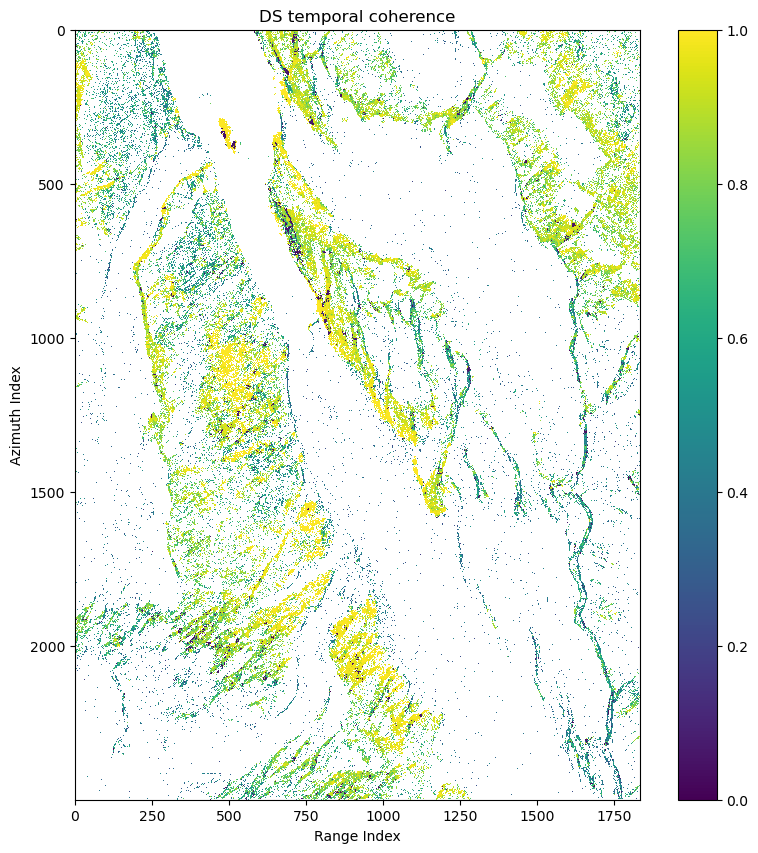

In [ ]:
t_coh_zarr = zarr.open(t_coh,mode='r')
fig, ax = plt.subplots(1,1,figsize=(10,10))
pcm = ax.imshow(t_coh_zarr[:],interpolation='nearest',vmin=0.0,vmax=1.0)
ax.set(title='DS temporal coherence',xlabel='Range Index',ylabel='Azimuth Index')
fig.colorbar(pcm)
plt.show()

Or with raster data:

In [ ]:
rslc = 'raw/rslc.zarr/'
intf = 'dl/n2f_intf.zarr'
tcoh = 'pqm/n2f_tcoh.zarr'
tnet = mr.TempNet.from_bandwidth(zarr.open(rslc,mode='r').shape[-1],1)

In [ ]:
temp_coh(intf,rslc,tcoh,image_pairs=tnet.image_pairs)

2025-09-20 23:15:19 - log_args - INFO - running function: temp_coh
2025-09-20 23:15:19 - log_args - INFO - fetching args:
2025-09-20 23:15:19 - log_args - INFO - intf = 'dl/n2f_intf.zarr'
2025-09-20 23:15:19 - log_args - INFO - rslc = 'raw/rslc.zarr/'
2025-09-20 23:15:19 - log_args - INFO - t_coh = 'pqm/n2f_tcoh.zarr'
2025-09-20 23:15:19 - log_args - INFO - image_pairs = array([[ 0,  1],
       [ 1,  2],
       [ 2,  3],
       [ 3,  4],
       [ 4,  5],
       [ 5,  6],
       [ 6,  7],
       [ 7,  8],
       [ 8,  9],
       [ 9, 10],
       [10, 11],
       [11, 12],
       [12, 13],
       [13, 14],
       [14, 15],
       [15, 16]], dtype=int32)
2025-09-20 23:15:19 - log_args - INFO - chunks = None
2025-09-20 23:15:19 - log_args - INFO - cuda = False
2025-09-20 23:15:19 - log_args - INFO - processes = None
2025-09-20 23:15:19 - log_args - INFO - n_workers = None
2025-09-20 23:15:19 - log_args - INFO - threads_per_worker = None
2025-09-20 23:15:19 - log_args - INFO - rmm_pool_size

or with gpu:

In [ ]:
if is_cuda_available():
    temp_coh(intf,rslc,tcoh,image_pairs=tnet.image_pairs,cuda=True)

2025-09-20 23:15:20 - log_args - INFO - running function: temp_coh
2025-09-20 23:15:20 - log_args - INFO - fetching args:
2025-09-20 23:15:20 - log_args - INFO - intf = 'dl/n2f_intf.zarr'
2025-09-20 23:15:20 - log_args - INFO - rslc = 'raw/rslc.zarr/'
2025-09-20 23:15:20 - log_args - INFO - t_coh = 'pqm/n2f_tcoh.zarr'
2025-09-20 23:15:20 - log_args - INFO - image_pairs = array([[ 0,  1],
       [ 1,  2],
       [ 2,  3],
       [ 3,  4],
       [ 4,  5],
       [ 5,  6],
       [ 6,  7],
       [ 7,  8],
       [ 8,  9],
       [ 9, 10],
       [10, 11],
       [11, 12],
       [12, 13],
       [13, 14],
       [14, 15],
       [15, 16]], dtype=int32)
2025-09-20 23:15:20 - log_args - INFO - chunks = None
2025-09-20 23:15:20 - log_args - INFO - cuda = True
2025-09-20 23:15:20 - log_args - INFO - processes = None
2025-09-20 23:15:20 - log_args - INFO - n_workers = None
2025-09-20 23:15:20 - log_args - INFO - threads_per_worker = None
2025-09-20 23:15:20 - log_args - INFO - rmm_pool_size 

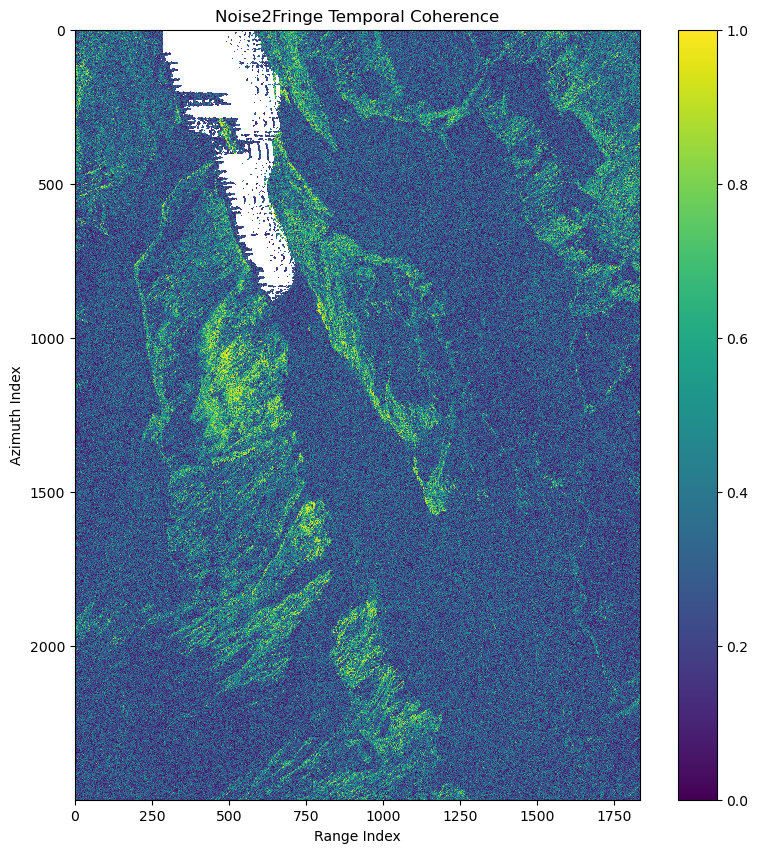

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
pcm = ax.imshow(zarr.open(tcoh,mode='r')[:],interpolation='nearest',vmin=0.0,vmax=1.0)
ax.set(title='Noise2Fringe Temporal Coherence',xlabel='Range Index',ylabel='Azimuth Index')
fig.colorbar(pcm)
fig.show()

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()